
# Seattle City Light Landslide Model 

Here we explore groundwater-driven shallow landsliding in the Skagit River Watershed above the confluence with Sauk River. 

This Jupyter Notebook runs the Landlab LandslideProbability component on a 30-m digital elevation model (DEM) using depth to groundwater from the Distributed Hydrology Soil and Vegetation (DHSVM) hydrologic model.

This notebook performs the following functions:<br >
1) Import libraries and set HydroShare variables<br />
2) Review data needed as input for the landslide model<br />
3) Create a RasterModelGrid based on a 30-m DEM<br />
4) Access and assign data fields used to calculate landslide probability<br />
5) Set Number of iterations to run Monte Carlo simulation<br />
6) Specify goundwater option as _data driven spatial_ and access NetCDF to generate groundwater depth distributions<br /> 
7) Run Landlab LandslideProbability component<br /> 
8) Adjust root cohession to simulate fire and run Landlab LandslideProbability Component<br />
9) Display and visualize results of stability analysis<br /> 
<br /> 


## To run this notebook:

To run this example, click in each shaded cell below and "shift + enter" to run each cell. Alternatively, you can run groups of cells by clicking "Cell" on the menu above and selecting you run option. This is also where you can clear outputs from previous runs.

If an error occurs, try "Restart" the kernel by clicking "Kernel" on the menu above.

## 1.  HydroShare Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading. and creation. Additional libraries support the functions of Landlab.

### Import libraries

In [4]:
#import Python utilities for calculating and plotting
import six
import os
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle

import warnings
print('Ignore deprecation warnings')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

#import utilities for importing and exporting to HydroShare
from utilities import hydroshare
# set variables for interacting with HydroShare from this notebook
hs=hydroshare.hydroshare()
# Create object to map the home directory
homedir = os.getcwd()
print('Data will be loaded from and saved to:'+homedir)
os.chdir('/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents')
print(homedir)

# Import Landlab libraries
import landslide_probability

from landslide_probability_20191202 import LandslideProbability
from landlab import RasterModelGrid
from landlab import imshow_grid_at_node
# from landlab.plot.imshow import imshow_node_grid
from landlab.io import read_esri_ascii
from landlab.io import write_esri_ascii
from collections import defaultdict
from landlab.io.netcdf import read_netcdf
from landlab.io.netcdf import write_netcdf

import time
st = time.time()

Ignore deprecation warnings
Successfully established a connection with HydroShare
Data will be loaded from and saved to:/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents
/home/jovyan/work/notebooks/data/4cac25933f6448409cab97b293129b4f/4cac25933f6448409cab97b293129b4f/data/contents


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon in upper rigth corner to see a File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

### Import data
 This data was preprocessed for the Seattle City Light case study and is on HydroShare as [Slippery Future Data: Predicting future regional landslide probability using soil saturation](https://www.hydroshare.org/resource/01b486f301864828ba2cd9ab7ac77c4e/). Click on the link to see the data repository on HydroShare.

Set a variable name for the data resource using the HydroShare resource ID.

In [5]:
Data_ResourceID='01b486f301864828ba2cd9ab7ac77c4e'

Execute the next cell to download data from another HydroShare resource - this may take a minute.

In [8]:
hs.getResourceFromHydroShare(Data_ResourceID)
data_folder = '/home/jovyan/work/notebooks/data/'+ Data_ResourceID +'/'+Data_ResourceID+'/data/contents/ASCII_Files/'
print('This is the location on the HydroShare JupyterHub server where the data has just been downloaded:')
print(data_folder)

This resource already exists in your userspace.
01b486f301864828ba2cd9ab7ac77c4e/
|-- 01b486f301864828ba2cd9ab7ac77c4e/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- ASCII_Files/
|   |   |   |   |-- glacier_scl_exclusion.txt
|   |   |   |   |-- goodell_fire.txt
|   |   |   |   |-- noca_landslidetype.txt
|   |   |   |   |-- phi28-40_30m.txt
|   |   |   |   |-- scl_coh_max.txt
|   |   |   |   |-- scl_coh_min.txt
|   |   |   |   |-- scl_coh_mod.txt
|   |   |   |   |-- scl_dem_30m.txt
|   |   |   |   |-- scldomain_header_30m.txt
|   |   |   |   |-- scl_domain_mask_30m.txt
|   |   |   |   |-- scl_lulc_8c.txt
|   |   |   |   |-- scl_slope_tan.txt
|   |   |   |   |-- scl_soildepth_1-3m.txt

Do you want to overwrite these data [Y/n]? n


This is the location on the HydroShare JupyterHub server where the data has just been downloaded:
/home/jovyan/work/notebooks/data/01b486f301864828ba2cd9ab7ac77c4e/01b486f301864828ba2cd9ab7ac77c4e/data/contents/ASCII_Files/


 ## 2. Review data needed as input for the landslide model


Check the list of data inputs that the component needs.

In [4]:
sorted(LandslideProbability.input_var_names)

['soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area']

Review the details of what each variable represents.

In [5]:
LandslideProbability._var_doc

{'landslide__probability_of_failure': 'number of times FS is <=1 out of number of iterations user selected',
 'soil__density': 'wet bulk density of soil',
 'soil__internal_friction_angle': 'critical angle just before failure due to friction between particles',
 'soil__maximum_total_cohesion': 'maximum of combined root and soil cohesion at node',
 'soil__mean_relative_wetness': 'Indicator of soil wetness; relative depth perched water table within the soil layer',
 'soil__mean_watertable_depth': 'mean distance to groundwater table from distribution of depths to groundwater or saturated soils',
 'soil__minimum_total_cohesion': 'minimum of combined root and soil cohesion at node',
 'soil__mode_total_cohesion': 'mode of combined root and soil cohesion at node',
 'soil__probability_of_saturation': 'number of times relative wetness is >=1 out of number of iterations user selected',
 'soil__saturated_hydraulic_conductivity': 'mode rate of water transmitted through soil - provided if transmissi

Check the units of each variable.

In [6]:
LandslideProbability._var_units

{'landslide__probability_of_failure': 'None',
 'soil__density': 'kg/m3',
 'soil__depth_to_groundwater': 'm',
 'soil__internal_friction_angle': 'degrees',
 'soil__maximum_total_cohesion': 'Pa or kg/m-s2',
 'soil__mean_relative_wetness': 'None',
 'soil__mean_watertable_depth': 'm',
 'soil__minimum_total_cohesion': 'Pa or kg/m-s2',
 'soil__mode_total_cohesion': 'Pa or kg/m-s2',
 'soil__probability_of_saturation': 'None',
 'soil__saturated_hydraulic_conductivity': 'm/day',
 'soil__thickness': 'm',
 'soil__transmissivity': 'm2/day',
 'topographic__slope': 'tan theta',
 'topographic__specific_contributing_area': 'm'}

Now we will establish a RasterModelGrid based on a DEM for assigning our variables to.
Nodes are the center point of grid cells or pixels that are 30 m by 30 m in this example. 

## 3. Create a RasterModelGrid based on a 30-m DEM

#### Load  landslide model inputs from ASCII textfile (ArcGIS raster conversion) into Landlab grid

Load DEM elevation grid<br />
Set_nodata_nodes_to_inactive that have no data (e.g., -9999), which establishes boundary conditions<br />
This might take a few minutes as the are is large.

In [9]:
(grid, z) = read_esri_ascii(data_folder+'/scl_dem_30m.txt',name='topographic__elevation')
grid.at_node.keys()     # loads DEM grid with elevation
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__elevation'], -9999) # set boundary conditions closed where no data

Confirm the size of the grid, nodes located every 30 m.

In [10]:
grid.number_of_nodes

7412000

Now we will attach data to this grid

## 4. Access and assign data fields to grid used to calculate landslide probability and set boundary conditions

#### For each input below
1. Load data from ascii text file
2. Assign grid to Landlab node
3. Set boundary conditions

For the SCL extent, this takes ~60 sec to load each file on NCSA ROGER super computer. 

Load slope (this is in tan theta)


In [9]:
(grid1, slope) = read_esri_ascii(data_folder+'/scl_slope_tan.txt')
grid.add_field('node', 'topographic__slope', slope)
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__slope'], -9999)
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__slope'], 0.0)

Load cohesion (mode, min, and max) - this takes ~3 minutes because 3 cohesion fields are provided to create more flexibility in how cohesion is distributed on the landscape.

In [10]:
(grid1, C) = read_esri_ascii(data_folder+'/scl_coh_mod.txt')
C[C == 0.0] = 1.0  # ensure minimum is >0 Pa for use in distributions generation
grid.add_field('node', 'soil__mode_total_cohesion', C)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__mode_total_cohesion'], -9999)

(grid1, C_min) = read_esri_ascii(data_folder+'/scl_coh_min.txt')
grid.add_field('node', 'soil__minimum_total_cohesion', C_min)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__minimum_total_cohesion'], -9999)

(grid1, C_max) = read_esri_ascii(data_folder+'/scl_coh_max.txt')
grid.add_field('node', 'soil__maximum_total_cohesion', C_max)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__maximum_total_cohesion'], -9999)

Load internal angle of friction

In [11]:
(grid1, phi) = read_esri_ascii(data_folder+'/phi28-40_30m.txt')
grid.add_field('node', 'soil__internal_friction_angle', phi)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__internal_friction_angle'], -9999)

Set soil density value and assign to all nodes as a constant

In [12]:
grid['node']['soil__density'] = 2000*np.ones(grid.number_of_nodes)

Load soil thickness or depth

In [13]:
(grid1, hs) = read_esri_ascii(data_folder+'/scl_soildepth_1-3m.txt')
grid.add_field('node', 'soil__thickness', hs)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__thickness'], -9999)

Load analysis mask to exclude areas outside the Skagit River Watershed

In [14]:
(grid1, mask) = read_esri_ascii(data_folder+'/scl_domain_mask_30m.txt')
grid.add_field('node', 'exclusion_mask', mask)
grid.set_nodata_nodes_to_closed(grid.at_node['exclusion_mask'], -9999)

Load observed landslide inventory within North Cascades National Park for later plotting. There are 6 classes of landslides: rock fall or topple (1), debris torrent (2), debris avalanche (3), slump or creep (4), snow avalanche-impacted (5), and sackung (6).

In [15]:
(grid1, slides) = read_esri_ascii(data_folder+'/noca_landslidetype.txt')
grid.add_field('node', 'landslides', slides)

array([-9999., -9999., -9999., ..., -9999., -9999., -9999.])

Load landcover classes to use for examining patterns in results.  There are 8 classes: forest (41), shrubs (52), herbaceous (71), wetland (90), developed (21), barren (31), ice & snow (12), and water (11).  Exclude the last 2 classes from analysis as landslides based on this approach are not modeled in water bodies.

In [16]:
(grid1, lulc) = read_esri_ascii(data_folder+'/scl_lulc_8c.txt')
grid.add_field('node', 'landcover', lulc)
grid.set_nodata_nodes_to_closed(grid.at_node['landcover'], 12)
grid.set_nodata_nodes_to_closed(grid.at_node['landcover'], 11)

Load area of Goodell Creek Fire (2015) located within Skagit River Watershed. Use this area to adjust root cohesion.

In [17]:
(grid1, fire) = read_esri_ascii(data_folder+'/goodell_fire.txt')
grid.add_field('node', 'fire_mask', mask)
#grid.set_nodata_nodes_to_closed(grid.at_node['fire_mask'], -9999)

array([-9999., -9999., -9999., ..., -9999., -9999., -9999.])

Load area of mapped glaciers and exclude from analysis

In [18]:
(grid1, glaciers) = read_esri_ascii(data_folder+'/glacier_scl_exclusion.txt')
grid.add_field('node', 'glacier_mask', glaciers)
grid.set_nodata_nodes_to_closed(grid.at_node['glacier_mask'], 1)

## 6. Specify Data Driven Spatial Depth to Water  (DTW) Distribution

There are _four_ different options for providing recharge or depth for the Monte Carlo simulation.  We'll provide each of these recharge options below by specifying a recharge or depth distribution and the necessary parameters. <br /> 
##### Restart opportunity: After completing this entire notebook, go to the Dashboard, Kernal, and select Restart and Clear Output.  Execute the code from the beginning, but change the cells below to adjust the recharge distributions.

### Saturation Option - 'data driven' distribution 
 
In this option, we'll apply a uniform distribution of recharge based on minimum and maximum recharge values.  We will then instantiate the LandslideProbability component with these parameters, as well as the grid and number of iterations we specified above.  Instantiate creates an instance of a class.  (For example, the _iPhone_ is a class and _each phone_ is an instance.)

No outputs are generated by these commands as they are setting up the recharge and instantiating the component.

In [2]:
distribution1 = 'data_driven_spatial'

### Use NetCDF data fields used to calculate landslide probability

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import itertools

#### Import netcdf file with xarray; view dataset

In [4]:
input_filename='dtw_G_CNRM_CM5__rcp45.nc'
data = xr.open_dataset(input_path)
data

<xarray.Dataset>
Dimensions:  (time: 62, x: 2725, y: 2720)
Coordinates:
  * time     (time) object '01/08/2039-21' '05/20/2040-21' ... '12/04/2099-21'
  * y        (y) int32 5436480 5436450 5436420 ... 5354970 5354940 5354910
  * x        (x) int32 591330 591360 591390 591420 ... 672990 673020 673050
Data variables:
    wt       (time, y, x) float64 ...

#### Calculate mean depth to water table for entire model space and time domains

In [5]:
wt_domain_mean=data.mean()
wt_domain_mean

<xarray.Dataset>
Dimensions:  ()
Data variables:
    wt       float64 0.1488

#### Calculate mean depth to water table for each year; print max value in the dataset

In [6]:
all_grids_mean = data.wt.mean("time")
all_grids_mean.max()

/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'wt' ()>
array(1.757163)

In [7]:
all_grids_std = data.wt.std("time")
all_grids_std.max()

<xarray.DataArray 'wt' ()>
array(0.708317)

In [8]:
all_grids_mean.plot()

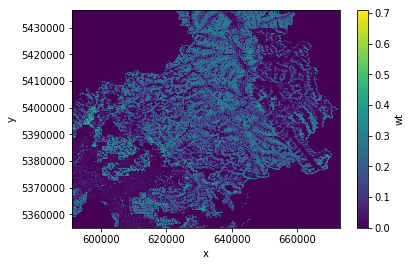

In [9]:
all_grids_std.plot()

In [10]:
wt_mean_dataframe=all_grids_mean.to_pandas()
wt_std_dataframe=all_grids_std.to_pandas()

In [11]:
nparray_wt_mean=wt_mean_dataframe.values.flatten()
nparray_wt_std=wt_std_dataframe.values.flatten()

print(len(nparray_wt_mean))
keys=np.arange(len(nparray_wt_mean))
print(len(keys))

7412000
7412000


In [13]:
list = [0] * len(keys)

i = 0
while i < len(list):
    list[i] = np.random.normal(nparray_wt_mean[i], nparray_wt_std[i],10)
    i += 1

print(list[5000000])


[0.14423333 0.06438703 0.16888394 0.14600893 0.11246884 0.0922455
 0.06612966 0.01609165 0.11846276 0.12824217]


In [14]:
i=5000000
np.random.normal(nparray_wt_mean[i], nparray_wt_std[i],10)


array([0.12121929, 0.15421388, 0.11687541, 0.04796438, 0.08952529,
       0.12709856, 0.1063781 , 0.08967094, 0.23132252, 0.06526223])

#### Check spatial mean of depth to water table in the first year

In [24]:
first_year = data.isel(time=[0]).mean()
first_year

<xarray.Dataset>
Dimensions:  ()
Data variables:
    wt       float64 0.2938

In [25]:
mean_wt_dict = dict(zip(keys, nparray_wt_mean))
std_wt_dict = dict(zip(keys, nparray_wt_std))


In [65]:
mean_wt_dict

{0: 0.0,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 0.0,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,
 49: 0.0,
 50: 0.0,
 51: 0.0,
 52: 0.0,
 53: 0.0,
 54: 0.0,
 55: 0.0,
 56: 0.0,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 60: 0.0,
 61: 0.0,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 65: 0.0,
 66: 0.0,
 67: 0.0,
 68: 0.0,
 69: 0.0,
 70: 0.0,
 71: 0.0,
 72: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 76: 0.0,
 77: 0.0,
 78: 0.0,
 79: 0.0,
 80: 0.0,
 81: 0.0,
 82: 0.0,
 83: 0.0,
 84: 0.0,
 85: 0.0,
 86: 0.0,
 87: 0.0,
 88: 0.0,
 89: 0.0,
 90: 0.0,
 91: 0.0,
 92: 0.0,
 93: 0.0,
 94: 0.0,
 95: 0.0,
 96: 0.0,
 97: 0.0,
 98: 0.0,
 99: 0.0,
 100: 0.0,

In [22]:
HSD_dict_stat_annualmaxDWT = dict(zip(keys, tuple(map(tuple, list))))


In [23]:
HSD_dict_stat_annualmaxDWT

{0: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 1: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 2: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 3: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 4: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 5: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 6: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 7: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 8: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 9: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 10: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 11: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 12: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 13: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 14: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 15: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 16: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0),
 17: (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
import pickle
mean_wt_dict 
std_wt_dict 
nparray_wt_mean
nparray_wt_std

with open('HSD_dict_stat_annualmaxDWT.pickle', 'wb') as handle:
    pickle.dump(HSD_dict_stat_annualmaxDWT, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 5. Set Number of iterations to run Monte Carlo simulation

The landslide component employes the infinite slope model to calculate factor-of-safety index values using a Monte Carlo simulation, which randomly selects input values from parameter distributions. You can specify the number of iterations to run Monte Carlo simulation, but the default is 250. The higher the number of iteration, the longer the program runs, but the more precise the probability of failure results become.

In [7]:
iterations = 50
n=50

## 7. Run the Landlab LandslideProbability Component

To run the landslide model, we first instantiate the LandslideProbability component with the above parameters, as well as the grid and number of iterations we specified before. Instantiate creates an instance of a class. (For example, the iPhone is a class and each phone is an instance.)

No outputs are generated by this command as it is setting up the recharge and instantiating the component.

In [24]:
LS_prob1=LandslideProbability(grid, number_of_iterations=n,
                     groundwater__depth_distribution='data_driven_spatial',
                     groundwater__depth_HSD_inputs=[HSD_dict_annualmaxDWT])

NameError: name 'LandslideProbability' is not defined

Once the component has been instantiated, we generate outputs from running the component by calling the component's 'calculate_landslide_probability' method using the class instance (e.g., LS_prob). The following cell runs the model; in the following section we will assessing the results. These calculations will take a few minutes given the size of the modeling domain represented by core nodes.

In [ ]:
LS_prob.calculate_landslide_probability()
print('Landslide probability successfully calculated')

The outputs of landslide model simulation are:

In [29]:
sorted(LS_prob.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__mean_watertable_depth',
 'soil__probability_of_saturation']

Save the arrays as variables by 'attaching the fields to the grid' and view the outputs. **component already does this**

This simulation generates a probability value for each core node. 

In [ ]:
LS_prob_probability_of_failure = grid.at_node['landslide__probability_of_failure']
grid.at_node['landslide__probability_of_failure']

This simulation generates a mean relative wetness value for each core node as well.

In [ ]:
LS_prob_relative_wetness = grid.at_node['soil__mean_relative_wetness']
grid.at_node['soil__mean_relative_wetness']

In [ ]:
fig = plt.figure('Water Table Depth Calculations')
xticks = np.arange(-0.1, 1.6, 0.8)


ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid_at_node(grid, 'soil__thickness', plot_name='soil (m)',
                    allow_colorbar=True, cmap='copper_r',
                    grid_units=('coordinates', 'coordinates'))

ax2 = fig.add_subplot(222)
ax2.set_xticks(xticks)
imshow_grid_at_node(grid, 'soil__mean_relative_wetness', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='mean_rw', var_units='m')

ax3 = fig.add_subplot(223)
ax3.set_xticks(xticks)
imshow_grid_at_node(grid, 'soil__probability_of_saturation', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='prob Sat', var_units='-')
ax4 = fig.add_subplot(224)
ax4.xaxis.set_visible(False)
imshow_grid_at_node(grid,'landslide__probability_of_failure', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='prob_failure', var_units='-')

plt.figure('Slope')
imshow_grid_at_node(grid,'topographic__slope', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
plt.savefig('Slope.png')


## 8. Stability analysis following fire

Make a coy of original grid and then reduce root cohesion 30% where fire burned vegetation

In [ ]:
import copy
grid_fire=copy.deepcopy(grid)
fire_reduction = 0.7
grid_fire.at_node['soil__mode_total_cohesion']=grid.at_node['soil__mode_total_cohesion']*fire_reduction
grid_fire.at_node['soil__minimum_total_cohesion']=grid.at_node['soil__minimum_total_cohesion']*fire_reduction
grid_fire.at_node['soil__maximum_total_cohesion']=grid.at_node['soil__maximum_total_cohesion']*fire_reduction


Compare the cohesion values of the 2 grids.

In [ ]:
print(np.max(grid.at_node['soil__minimum_total_cohesion'][grid.core_nodes]))
print(np.min(grid.at_node['soil__minimum_total_cohesion'][grid.core_nodes]))
print(np.max(grid_fire.at_node['soil__minimum_total_cohesion'][grid.core_nodes]))
print(np.min(grid_fire.at_node['soil__minimum_total_cohesion'][grid.core_nodes]))

Now we'll run the landslide component with the adjusted cohesion, everything else kept constant.

In [ ]:
LS_probFire = LandslideProbability(grid_fire,number_of_iterations=n,
    groundwater__depth_distribution=distribution1,
    groundwater__depth_min_value=Demin_value,
    groundwater__depth_max_value=Demax_value)

In [ ]:
LS_probFire.calculate_landslide_probability()
print('Landslide probability successfully calculated')

In [ ]:
fig = plt.figure('Water Table Depth Calculations')
xticks = np.arange(-0.1, 1.6, 0.8)


ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid_at_node(grid, 'soil__thickness', plot_name='soil (m)',
                    allow_colorbar=True, cmap='copper_r',
                    grid_units=('coordinates', 'coordinates'))

ax2 = fig.add_subplot(222)
ax2.set_xticks(xticks)
imshow_grid_at_node(grid, 'soil__mean_relative_wetness', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='mean_rw', var_units='m')

ax3 = fig.add_subplot(223)
ax3.set_xticks(xticks)
imshow_grid_at_node(grid, 'soil__probability_of_saturation', cmap='YlGnBu',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='prob Sat', var_units='-')
ax4 = fig.add_subplot(224)
ax4.xaxis.set_visible(False)
imshow_grid_at_node(grid,'landslide__probability_of_failure', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='prob_failure', var_units='-')

plt.figure('Slope')
imshow_grid_at_node(grid,'topographic__slope', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Slope', var_units='m/m')
plt.savefig('Slope.png')


## 9. Display and visualize results of stability analysis

Set plotting parameters

In [ ]:
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 15

Plot elevation

In [ ]:
plt.figure('Elevations from the DEM [m]')
imshow_grid_at_node(grid, 'topographic__elevation', cmap='terrain',
                 grid_units=('coordinates', 'coordinates'),
                 shrink=0.75, var_name='Elevation', var_units='m')
#plt.savefig('SCL_elevation.png')

Excluded areas from the analysis are shown in black, including outside the Skagit River Watershed and inside the watershed that are water, snow & ice, glaciers, and wetlands, and slopes=0 degrees. 

Plot slope overlaid with mapped 4 primary landslide types within national park. Takes about a few minutes.

In [ ]:
plt.figure('Landslides')
ls_mask1 = grid.at_node['landslides'] != 1.0
ls_mask2 = grid.at_node['landslides'] != 2.0
ls_mask3 = grid.at_node['landslides'] != 3.0
ls_mask4 = grid.at_node['landslides'] != 4.0
overlay_landslide1 = np.ma.array(grid.at_node['landslides'], mask=ls_mask1)
overlay_landslide2 = np.ma.array(grid.at_node['landslides'], mask=ls_mask2)
overlay_landslide3 = np.ma.array(grid.at_node['landslides'], mask=ls_mask3)
overlay_landslide4 = np.ma.array(grid.at_node['landslides'], mask=ls_mask4)
imshow_grid_at_node(grid, 'topographic__slope', cmap='pink',
                 grid_units=('coordinates', 'coordinates'), vmax=2.,
                 shrink=0.75, var_name='Slope', var_units='m/m')
imshow_grid_at_node(grid, overlay_landslide1, color_for_closed='None',
                 allow_colorbar=False, cmap='cool')
imshow_grid_at_node(grid, overlay_landslide2, color_for_closed='None',
                 allow_colorbar=False, cmap='autumn')
imshow_grid_at_node(grid, overlay_landslide3, color_for_closed='None',
                 allow_colorbar=False, cmap='winter')
imshow_grid_at_node(grid, overlay_landslide4, color_for_closed='None',
                 allow_colorbar=False,cmap='summer')
#plt.savefig('NOCA_Landslides_on_Slope.png')

Legend to mapped landslides: blue - debris avalanches, cyan - falls/topples, red - debris torrents, and green - slumps/creeps 

Plot of soil depth (m)

In [ ]:
plt.figure('Soil Thickness')
imshow_grid_at_node(grid, 'soil__thickness', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Soil Thickness', var_units='m')
#plt.savefig('NOCA_SoilDepth.png')

Plot probability of saturation 

In [ ]:
plt.figure('Probability of Saturation')
imshow_grid_at_node(grid, 'soil__probability_of_saturation', cmap='YlGnBu',
                 limits=((0), (1)),
                 grid_units=('coordinates', 'coordinates'),
                 shrink=0.75, var_name='Probability of Saturation',
                 var_units='no units')
#plt.savefig('NOCA_ProbabilityofSaturation.png')

This map shows the probability of saturation as high throughout much of the area because we modeled the annual maximum recharge, which is esssentially the worst case conditions that might lead to instability.

Plot probability of failure; Compare this with the elevation and slope maps.

In [ ]:
plt.figure('Probability of Failure')
imshow_grid_at_node(grid, 'landslide__probability_of_failure', cmap='OrRd',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Probability of Failure', var_units='no units')
#plt.savefig('NOCA_ProbabilityofFailure.png')

The map of probability of failure shows higher probabilities at higher elevations below retreating glaciers where vegation is sparse and shallow unconsolidated sediment is prevalent.

Let's compare the Probability of Failure between the before and after fire

In [ ]:
fig = plt.figure('Probability of Failures')
xticks = np.arange(-0.1, 1.6, 0.8)


ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid_at_node(grid, 'landslide__probability_of_failure', 
                    plot_name='Probability of Failure - Pre-fire',
                    allow_colorbar=True, cmap='OrRd',
                    grid_units=('coordinates', 'coordinates'), shrink=0.75,
                    var_name='Probability of Failure', var_units='no units')

ax2 = fig.add_subplot(212)
ax2.set_xticks(xticks)
imshow_grid_at_node(grid_fire, 'landslide__probability_of_failure', 
                    plot_name='Probability of Failure - Post-fire',
                    allow_colorbar=True, cmap='OrRd',
                    grid_units=('coordinates', 'coordinates'), shrink=0.75,
                    var_name='Probability of Failure', var_units='no units')


How long did the code above take to run?

In [ ]:
print 'Elapsed time is %3.2f seconds' % (time.time() - st)

To review the fields assigned to the grid, simply execute the following command.

In [ ]:
grid.at_node

Export data from model run: FS probability, mean Reletive wetness, probability of saturation

In [ ]:
import pandas as pd
core_nodes = grid.core_nodes
data_extracted = {'PF_3S_SD': np.array(
                 grid.at_node['landslide__probability_of_failure'][grid.core_nodes]),
                 'mean_RW': np.array(grid.at_node['soil__mean_relative_wetness']
                 [grid.core_nodes]),'prob_sat': np.array(
                 grid.at_node['soil__probability_of_saturation'][grid.core_nodes])}
headers = ['PF_3S_SD','mean_RW','prob_sat']
df = pd.DataFrame(data_extracted, index=core_nodes, columns=(headers))
df.to_csv('FS3k_SSD_demo.csv')

Make ascii files for raster creation in GIS

In [ ]:
write_esri_ascii('prbF_3kSSD_demo.txt',grid,names='landslide__probability_of_failure')
write_esri_ascii('mRW_3kSSD_demo.txt',grid,names='soil__mean_relative_wetness')
write_esri_ascii('prbSat_3kSSD_demo.txt',grid,names='soil__probability_of_saturation')